In [1]:
# Семинар 10: гетероскедастичность

import numpy as np
import pandas as pd # чтение файлов
import matplotlib.pyplot as plt # построение графиков
import seaborn as sns # построение графиков
import statsmodels.api as sm # тесты
import statsmodels
import statsmodels.stats.diagnostic as sm_diagnostic # тест Бройша-Пагана


import statsmodels.formula.api as smf

In [2]:
get_ipython().system('pip install rdatasets') # наборы данных
# !pip install pyreadstat # чтение spss/stata данных
from rdatasets import data 
# from pyreadstat import read_sav, set_value_labels

In [3]:
d = pd.read_excel('/Users/polinapogorelova/Desktop/Heterosk_5.xls')

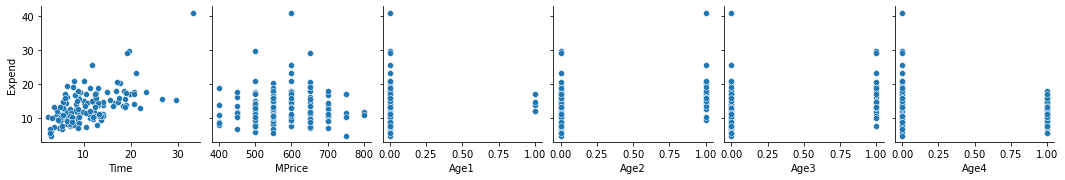

In [4]:
# Построим графики зависимостей затрат от факторов
sns.pairplot(d, x_vars = ["Time", "MPrice", "Age1", "Age2", "Age3", "Age4"], y_vars = ["Expend"])

In [5]:
reg = smf.ols("Expend ~ Time + MPrice + Age1 + Age2 + Age3 + Age4", d).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Expend   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     40.37
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           2.15e-28
Time:                        14:25:06   Log-Likelihood:                -370.85
No. Observations:                 149   AIC:                             755.7
Df Residuals:                     142   BIC:                             776.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3682      1.848      1.822      0.071      -0.285       7.022
Time           0.5022      0.045     11.124      0.000       0.413       0.591
MPrice         0.0045      0.003      1.519      0.131      -0.001       0.010
Age1           1.2654      1.462      0.865      0.388      -1.625       4.156
Age2           5.8639      0.790      7.422      0.000       4.302       7.426
Age3           5.3799      0.798      6.742      0.000       3.802       6.957
Age4           0.2737      0.633      0.433      0.666      -0.977       1.524
==============================================================================
Omnibus:                       20.582   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.673
Skew:                           0.567   Prob(JB):                     1.21e-10
Kurtosis:                       5.464   Cond. No.                     4.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
# Сохраним прогнозные значения
d['expend_pred'] = reg.predict()
# Сохраним остатки модели
d['resid'] = reg.resid
# Cоздадим переменную resid2 = resid^2
d['resid2'] = reg.resid**2
d

,Time,MPrice,Expend,Age1,Age2,Age3,Age4,Age5,expend_pred,resid,resid2
0,6.7,550,9.0,0,0,0,1,0,9.505400,-0.505400,0.255429
1,5.4,600,7.6,0,0,1,0,0,14.185975,-6.585975,43.375073
2,7.2,650,7.8,0,0,0,0,1,9.937136,-2.137136,4.567348
3,14.2,700,14.0,1,0,0,0,0,14.944859,-0.944859,0.892758
4,6.4,650,19.5,0,0,1,0,0,14.915321,4.584679,21.019277
...,...,...,...,...,...,...,...,...,...,...,...
144,7.6,750,10.4,0,0,0,1,0,10.866090,-0.466090,0.217240
145,13.2,600,11.2,0,0,0,1,0,12.996623,-1.796623,3.227855
146,10.5,650,7.3,0,0,0,1,0,11.867979,-4.567979,20.866433
147,7.6,650,9.0,0,0,0,0,1,10.137999,-1.137999,1.295042


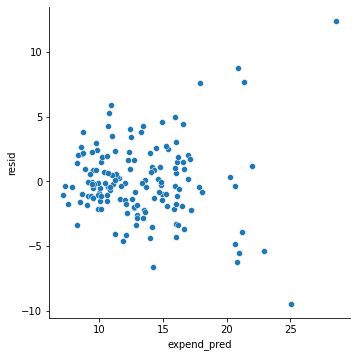

In [7]:
# Построим график зависимости остатков модели от прогнозных значений
sns.pairplot(d, x_vars=['expend_pred'], y_vars=["resid"], height = 5)

In [8]:
# Тест Бройша-Пагана (зависимость дисперсии от конкретных факторов)

X = d[["Time", "MPrice", "Age1", "Age2", "Age3", "Age4"]]
BP_test = sm_diagnostic.het_breuschpagan(resid=d['resid'], exog_het=X)
from statsmodels.compat import lzip
print(pd.DataFrame(lzip(['LM statistic', 'p-value',  'F-value', 'F: p-value'], BP_test)))

# Первое из выданных значений - значение тестовой статистики теста Бройша - Пагана, второе - значение p-value для выданной тестовой 
# статистики. 
# Третье и четвёртое - значения тестовой статистики и её p-value для на уровне значимости 5% (табличное). 
# Вывод: так как p-value=0 < 0.05, то гипотеза H1 не отвергается, то есть етероскедастичность присутствует.

              0             1
0  LM statistic  6.321401e+01
1       p-value  2.628663e-12
2       F-value  1.756231e+01
3    F: p-value  3.577289e-15


In [9]:
abs_reside = abs(d['resid'])
abs_reside

0      0.505400
1      6.585975
2      2.137136
3      0.944859
4      4.584679
         ...   
144    0.466090
145    1.796623
146    4.567979
147    1.137999
148    0.975622
Name: resid, Length: 149, dtype: float64

In [10]:
# Взвешенный МНК
# Для начала оценим реегрессию модуля остатков на kitsp

reg_w = smf.ols('abs_reside ~ Time', d).fit()
reg_w.summary()

# Модель значима, так как p-value=0 в F-тесте

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             abs_reside   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     27.52
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           5.33e-07
Time:                        14:25:33   Log-Likelihood:                -302.12
No. Observations:                 149   AIC:                             608.2
Df Residuals:                     147   BIC:                             614.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5853      0.329      1.778      0.078      -0.065       1.236
Time           0.1449      0.028      5.246      0.000       0.090       0.200
==============================================================================
Omnibus:                       30.770   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.440
Skew:                           1.108   Prob(JB):                     2.24e-10
Kurtosis:                       4.498   Cond. No.                         26.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# Зададим веса
reg_w.predict()
weight = reg_w.predict()**2
weight

array([ 2.42189364,  1.87100328,  2.65267642,  6.98624448,  2.28846447,
        5.60648015,  1.87100328,  6.53414781,  1.64068855,  3.35473374,
       10.76366581,  1.64068855,  5.00583281,  3.51588565,  6.60844715,
        3.79287301,  5.60648015,  2.7000931 ,  3.24939934,  5.26858677,
        2.8448634 ,  1.39109994,  2.89396024,  1.9918312 ,  3.24939934,
        1.91085921,  2.99341406,  6.02581358,  2.74792983,  3.09454805,
        4.0803614 , 10.01637595,  5.20226822,  8.01766241,  1.95113518,
        5.53806139,  7.61256237, 11.0508302 ,  5.00583281,  3.51588565,
        2.2016119 ,  3.62542047,  3.30185652,  3.62542047, 29.12381321,
        1.60377291,  5.00583281,  2.15881568,  4.1391192 ,  2.28846447,
       10.5743231 , 15.6968975 ,  3.09454805,  2.37699721,  2.28846447,
        6.83386543,  3.408031  ,  9.03274673,  1.49554624, 12.85320437,
        6.83386543,  1.04047337,  4.43920884,  5.81425668,  1.04047337,
        5.402484  , 23.62388531,  5.20226822,  1.29043401,  3.73

In [12]:
X = sm.add_constant(X) # добавим столбец из 1 в матрицу X, чтобы включить константу

# Оценим с помощью GLS (Feasible GLS) исходную модель регрессии
reg_wls = sm.WLS(d["Expend"], X, weights = weight).fit()
reg_wls.summary()

/Users/polinapogorelova/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 Expend   R-squared:                       0.631
Model:                            WLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     40.46
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           1.96e-28
Time:                        14:25:47   Log-Likelihood:                -439.83
No. Observations:                 149   AIC:                             893.7
Df Residuals:                     142   BIC:                             914.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9965      2.683      0.371      0.711      -4.307       6.300
Time           0.5390      0.051     10.606      0.000       0.439       0.639
MPrice         0.0074      0.005      1.626      0.106      -0.002       0.016
Age1           0.6004      1.930      0.311      0.756      -3.216       4.416
Age2           6.5357      1.091      5.989      0.000       4.379       8.693
Age3           6.3692      1.136      5.609      0.000       4.124       8.614
Age4           0.1066      0.915      0.116      0.907      -1.703       1.916
==============================================================================
Omnibus:                       63.443   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1476.092
Skew:                           0.844   Prob(JB):                         0.00
Kurtosis:                      18.327   Cond. No.                     4.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
# Второй способ корректировки гетероскедастичности - использование робастных оценок, например, в форме Уайта.

reg_robust = reg.get_robustcov_results(cov_type = 'HC3')
reg_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Expend   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     13.23
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           7.21e-12
Time:                        14:25:59   Log-Likelihood:                -370.85
No. Observations:                 149   AIC:                             755.7
Df Residuals:                     142   BIC:                             776.7
Df Model:                           6                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3682      2.044      1.647      0.102      -0.673       7.410
Time           0.5022      0.096      5.246      0.000       0.313       0.691
MPrice         0.0045      0.003      1.706      0.090      -0.001       0.010
Age1           1.2654      0.913      1.386      0.168      -0.540       3.070
Age2           5.8639      1.029      5.700      0.000       3.830       7.898
Age3           5.3799      0.916      5.875      0.000       3.570       7.190
Age4           0.2737      0.491      0.558      0.578      -0.696       1.243
==============================================================================
Omnibus:                       20.582   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.673
Skew:                           0.567   Prob(JB):                     1.21e-10
Kurtosis:                       5.464   Cond. No.                     4.45e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 4.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""